# 03b_overlap_cluster-tx_pwenrich_tx

calculated overlap of clusters and treatments

**IMPORTANT:** the gene lists for both treatments and clusters were are unique. List was ranked by fold change (treatment) or score (clusters) and the gene was assigned to the cluster/treatement with the to score/fold change. this is different to the overlap between clusters in Notebook 03a where duplicates were NOT excluded. 

- part 1: generation of overlaps between to top 100 genes in clusters and treatments
- part 2: pathway enrichment for treatments in LSKs and HSCs. 

docker image used:

docker run --rm -d --name gseapy -p 8885:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work gseapy:0.10.4 

In [1]:
#load some packages that are needed for plotting + computation

import os
import math
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import gseapy as gp
from math import floor, log10
%matplotlib inline

from gprofiler import GProfiler
from helper_functions import *


Creating directory /home/jovyan/.config/bioservices 


## Cluster overlap

In [2]:
cols_HSCs = ['primerid',
 'Unnamed: 0',
 'Pr(>Chisq)',
 'coef',
 'FDR',
 'Unnamed: 0LT_1',
 'Pr(>Chisq)LT_1',
 'coefLT_1',
 'FDRLT_1',
 'Unnamed: 0LT_2',
 'Pr(>Chisq)LT_2',
 'coefLT_2',
 'FDRLT_2',
 'Unnamed: 0LT_3',
 'Pr(>Chisq)LT_3',
 'coefLT_3',
 'FDRLT_3',
 'Unnamed: 0LT_4',
 'Pr(>Chisq)LT_4',
 'coefLT_4',
 'FDRLT_4',
 'Unnamed: 0LT_5',
 'Pr(>Chisq)LT_5',
 'coefLT_5',
 'FDRLT_5',
 'Unnamed: 0LT_all',
 'Pr(>Chisq)LT_all',
 'coefLT_all',
 'FDRLT_all']
cols_MPPs = ['primerid', 'Unnamed: 0MPPs_0',
 'Pr(>Chisq)MPPs_0',
 'coefMPPs_0',
 'FDRMPPs_0',
 'Unnamed: 0MPPs_1',
 'Pr(>Chisq)MPPs_1',
 'coefMPPs_1',
 'FDRMPPs_1',
 'Unnamed: 0MPPs_2',
 'Pr(>Chisq)MPPs_2',
 'coefMPPs_2',
 'FDRMPPs_2',
 'Unnamed: 0MPPs_3',
 'Pr(>Chisq)MPPs_3',
 'coefMPPs_3',
 'FDRMPPs_3',
 'Unnamed: 0MPPs_4',
 'Pr(>Chisq)MPPs_4',
 'coefMPPs_4',
 'FDRMPPs_4',
 'Unnamed: 0MPPs_5',
 'Pr(>Chisq)MPPs_5',
 'coefMPPs_5',
 'FDRMPPs_5',
 'Unnamed: 0MPPs_6',
 'Pr(>Chisq)MPPs_6',
 'coefMPPs_6',
 'FDRMPPs_6',
 'Unnamed: 0MPPs_7',
 'Pr(>Chisq)MPPs_7',
 'coefMPPs_7',
 'FDRMPPs_7',
 'Unnamed: 0MPPs_all',
 'Pr(>Chisq)MPPs_all',
 'coefMPPs_all',
 'FDRMPPs_all']

## HSCs

In [3]:
# define total number of genes for background dataset - genes that can be measured in scRNAseq - based on the single cell objects
# LSK was 13,827, HSC was 14,408 - take 14,000

total_n = 14000

In [4]:
cluster_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_clusters_final_all_genes.csv')

In [5]:
cl_list = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

df_cl =pd.DataFrame(columns=['primerid', 'specific', 'score'])

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()[:200]
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()[:200]
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_cl = df_cl.append(results_df, ignore_index=True)

df_cl = df_cl.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_cl = df_cl.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score

In [6]:
files = ['1.2', '1.5', 'nocutoff']
file = '1.2'
treatments = ['dmPGE2', 'GCSF', 'pIC', 'indo']

df_st =pd.DataFrame()

for treatment in treatments:
    base_file = '/home/jovyan/work/Z_TRASH/write/'
    file_name = base_file + '/MAST_overlap_' + file + '_' + treatment + '_all.csv'
    df_temp = pd.read_csv(file_name)
    df_temp = df_temp[cols_HSCs]
    df_temp = df_temp.dropna(axis=0, thresh=2) #drop genes with 'NAs'
    df_temp['stimulant'] = treatment
    df_st = df_st.append(df_temp)

df_st['max_coef'] = df_st.filter(regex='coef').max(axis=1)   
df_st = df_st.sort_values(by='max_coef', ascending=False) # this is to get rid of duplicates
df_st = df_st.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score
 
df = df_st.copy()

### cluster overlap

In [7]:
stimuli = [ 'GCSF', 'pIC', 'indo', 'dmPGE2']
clusters = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Cell-cycle']

result_df_cl = pd.DataFrame(columns = ['Gene', 'HSC cluster'])
result_df_tx = pd.DataFrame(columns = ['Gene', 'HSC treatment'])
result_df_save = pd.DataFrame()


results_df_list =[]
results_df = pd.DataFrame()

p_value_df_list = []
p_value_df = pd.DataFrame()

top_genes = 100

for st in stimuli:
    del result_df_cl
    result_df_cl = pd.DataFrame(columns = ['Gene', 'HSC cluster'])
    results_df_list =[]
    p_value_df_list =[]
    list1 = df_st[df_st['stimulant'] == st].sort_values(by='max_coef', ascending=False)['primerid'].tolist()[:top_genes]
    
    result_df_tx_temp = pd.DataFrame()
    result_df_tx_temp['Gene'] = list1
    result_df_tx_temp['HSC treatment'] = st
    result_df_tx = result_df_tx.append(result_df_tx_temp, ignore_index=True)

    
    for cl in clusters:
        
        list2 = df_cl[df_cl['specific'] == cl].sort_values(by='score', ascending=False)['primerid'].tolist()[:top_genes]
        
        result_df_cl_temp = pd.DataFrame()
        result_df_cl_temp['Gene'] = list2
        result_df_cl_temp['HSC cluster'] = cl
        result_df_cl = result_df_cl.append(result_df_cl_temp, ignore_index=True)
        
        intersection = len(list(set(list1).intersection(list2)))
        only_st = len(list1) - intersection
        only_cl = len(list2) - intersection
        rest = total_n - (only_st + only_cl + intersection)
       
        oddsratio, pvalue = stats.fisher_exact([[intersection, only_cl], [only_st, rest]], alternative='greater')
        
        results_df_list.append(intersection)
        p_value_df_list.append(pvalue)
    
    p_value_df_series = pd.Series(p_value_df_list)
    p_value_df = p_value_df.append(p_value_df_series, ignore_index=True)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

p_value_df, rej = multiple_testing_correction(ps = p_value_df, 
                                                   alpha=0.01,
                                                   method='benjamini-hochberg')
p_value_df = pd.DataFrame(p_value_df) 

result_df_save = result_df_cl.merge(result_df_tx, how='outer', on='Gene')
result_df_save.to_csv('/home/jovyan/work/Z_TRASH/write/HSC_treatment_cluster_overlap.csv', index=False, header=True)

In [8]:
results_df.columns = clusters
results_df.index = stimuli


p_value_df.columns = clusters
p_value_df.index = stimuli

p_value_mask_sig = p_value_df > 0.01
p_value_mask_nonsig = p_value_df < 0.01

In [9]:
p_value_df

,Metabolism,Quiescent,Activated,Interferon,Cell-cycle
GCSF,8.222141e-49,1.000000,1.000000e+00,1.000000e+00,1.0
pIC,1.000000e+00,1.000000,2.764975e-06,1.046666e-144,1.0
indo,1.000000e+00,0.140355,2.785305e-05,1.000000e+00,1.0
dmPGE2,1.000000e+00,0.457299,7.260477e-17,1.000000e+00,1.0


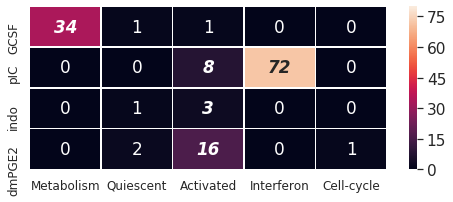

In [10]:
sns.set(font_scale=1.4)

plt.figure(figsize=(8,3))
#sns.heatmap(results_df, annot=True, annot_kws={"size": 16}, mask = p_value_mask)
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=0, fontsize = 12)


sns.heatmap(results_df,
            mask = p_value_mask_sig,
            linewidth=0.5,
            annot_kws={"style": "italic", "weight": "bold"},
            annot=True,
            vmin=0, vmax=80)


sns.heatmap(results_df,
            mask = p_value_mask_nonsig,
            linewidth=0.5,
            cbar=False,
            annot=True,
            vmin=0, vmax=80)

plt.savefig("/home/jovyan/work/Z_TRASH/figures/overlap_clusters_treatment_diff_genes_HSCs_July21.pdf", dpi=300, bbox_inches='tight')

### pathway enrich tx

In [11]:
# make dictionary with curated pathways

dst ='/home/jovyan/work/Z_TRASH/raw_data/gene_sets'
out ='/home/jovyan/work/Z_TRASH/write/'

pw_files = os.listdir(dst)

pw_dic = {}

for file in pw_files:
    df_temp = pd.read_csv(dst + '/' + file, delimiter = "\t")
    list_temp = df_temp.iloc[:,0].tolist()[1:]
    list_temp = [x.capitalize() for x in list_temp] #convert to capitalize
    pw_dic[file[:-4]] = list_temp

del pw_dic['.DS_S']    

pd.DataFrame.from_dict(pw_dic,orient='index').T.to_csv(out + 'curated_pathways.csv', index=False, header=True)

In [12]:
df_save = pd.DataFrame(columns =['Treatment', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

cl_list = ['dmPGE2', 'GCSF', 'pIC', 'indo']

for cl in cl_list:
    
      
    temp_df = pd.DataFrame()
    df_final = pd.DataFrame(columns =['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

    gene_list = df_st[(df_st['stimulant']==cl) & (df_st['max_coef'] > math.log2(1.2))]['primerid'].tolist()
    
    sources = ["GO:BP"]
    temp_df = pathway_enrich_genes_new(gene_list, sources).head(4)
    temp_df = col_select(temp_df)  
    df_final = df_final.append(temp_df, ignore_index=True)

    sources = ["REAC"]
    temp_df = pd.DataFrame()
    temp_df = pathway_enrich_genes_new(gene_list, sources).head(4)
    temp_df = col_select(temp_df)  
    df_final = df_final.append(temp_df, ignore_index=True)
    
    enr_res = gp.enrichr(gene_list=gene_list,
                             organism='Mouse',
                             gene_sets= pw_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.01)

    temp_df = enr_res.results[enr_res.results['Adjusted P-value'] < 0.01]
    temp_df = temp_df.sort_values(by = 'Adjusted P-value', axis=0, ascending=True).head(6)

    temp_df['Gene Overlap'] = temp_df['Overlap']
    temp_df['Gene names'] = temp_df['Genes']
    
    # extract conditions
    pw_list = []
    origin_list = []
    for index, row in temp_df.iterrows():
        pw = 0
        origin = 0
        pw = row['Term'].split("_", 1)[0]
        origin = row['Term'].split("_", 1)[1] 
        pw_list.append(pw)
        origin_list.append(origin)

    temp_df['Origin'] = pw_list
    temp_df['Pathway'] = origin_list

    temp_df = temp_df[['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]

    df_final = df_final.append(temp_df, ignore_index=True)
    df_final['Adjusted P-value'] = df_final['Adjusted P-value'].apply(lambda x: round(x, 1 - int(floor(log10(abs(x))))))
    df_final['Treatment'] = cl
    df_final = df_final[['Treatment', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]
    df_save = df_save.append(df_final, ignore_index=True)
    
df_save.to_csv('/home/jovyan/work/Z_TRASH/write/HSC_treatment_enrichment.csv', index=False, header=True)

2021-09-02 20:32:47,174 Warning: No enrich terms using library CUSTOM139753620597352 when cutoff = 0.01
2021-09-02 20:32:52,913 Warning: No enrich terms using library CUSTOM139753620597352 when cutoff = 0.01


In [13]:
# check GCSF separately in HSCs

cl = 'GCSF'

gene_list = df_st[(df_st['stimulant']==cl) & (df_st['max_coef'] > math.log2(1.2))]['primerid'].tolist()

enr_res = gp.enrichr(gene_list=gene_list,
                             organism='Mouse',
                             gene_sets= pw_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.01)

enr_res.results

2021-09-02 20:32:53,204 Warning: No enrich terms using library CUSTOM139753620597352 when cutoff = 0.01


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Genes
0,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_8H_BMDC_DN,1/199,0.612132,0.661217,Eif2s2
1,CUSTOM139753620597352,GSE21033_CTRL_VS_POLYIC_STIM_DC_12H_DN,3/200,0.068338,0.239182,Ldha;Wdr43;G3bp1
2,CUSTOM139753620597352,GSE21033_CTRL_VS_POLYIC_STIM_DC_1H_DN,3/198,0.066731,0.239182,Ybx3;Cdv3;Eif4a1
3,CUSTOM139753620597352,CHEMNITZ_RESPONSE_TO_PROSTAGLANDIN_E2_UP,1/147,0.502567,0.661217,Eif4ebp1
4,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_0.5H_BMDC_UP,2/200,0.243010,0.567023,Lrrc59;Eif2s2
5,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_12H_BMDC_DN,3/200,0.068338,0.239182,Cacybp;Gspt1;Eif2s2
6,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_1H_BMDC_DN,1/199,0.612132,0.661217,Hspa5
7,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_1H_BMDC_UP,1/200,0.613987,0.661217,Eif3b
8,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_24H_BMDC_DN,1/200,0.613987,0.661217,Nupr1
9,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_2H_BMDC_DN,2/200,0.243010,0.567023,Nop58;Nupr1


### LSKs

In [14]:
cluster_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_MPP_clusters_final_all_genes.csv')

In [15]:
# had to select the top 200 because otherwise edge case that Mpo is lost from Myeloid because it shows up in Metabolism with higher score but not in top 100

cl_list = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid']

df_cl =pd.DataFrame(columns=['primerid', 'specific', 'score'])

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()[:200]
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()[:200]
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_cl = df_cl.append(results_df, ignore_index=True)

df_cl = df_cl.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_cl = df_cl.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score

In [16]:
df_cl[df_cl['primerid']=='Mpo']

,primerid,specific,score
1431,Mpo,Myeloid,8.627026


In [17]:
files = ['1.2', '1.5', 'nocutoff']
file = '1.2'
treatments = ['dmPGE2', 'GCSF', 'pIC', 'indo']

df_st =pd.DataFrame()

for treatment in treatments:
    base_file = '/home/jovyan/work/Z_TRASH/write/'
    file_name = base_file + '/MAST_overlap_' + file + '_' + treatment + '_all.csv'
    df_temp = pd.read_csv(file_name)
    df_temp = df_temp[cols_MPPs]
    df_temp = df_temp.dropna(axis=0, thresh=2) #drop genes with 'NAs'
    df_temp['stimulant'] = treatment
    df_st = df_st.append(df_temp)

df_st['max_coef'] = df_st.filter(regex='coef').max(axis=1)   
df_st = df_st.sort_values(by='max_coef', ascending=False) # this is to get rid of duplicates
df_st = df_st.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score
 
df = df_st.copy()

In [18]:
del result_df_save
stimuli = [ 'GCSF', 'pIC', 'indo', 'dmPGE2']
clusters = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle','Myeloid']

result_df_cl = pd.DataFrame(columns = ['Gene', 'LSK cluster'])
result_df_tx = pd.DataFrame(columns = ['Gene', 'LSK treatment'])
result_df_save = pd.DataFrame()

results_df_list =[]
results_df = pd.DataFrame()

p_value_df_list = []
p_value_df = pd.DataFrame()

top_genes = 100

for st in stimuli:
    del result_df_cl
    result_df_cl = pd.DataFrame(columns = ['Gene', 'LSK cluster'])
    results_df_list =[]
    p_value_df_list =[]
    list1 = df_st[df_st['stimulant'] == st].sort_values(by='max_coef', ascending=False)['primerid'].tolist()[:top_genes]
    
    result_df_tx_temp = pd.DataFrame()
    result_df_tx_temp['Gene'] = list1
    result_df_tx_temp['LSK treatment'] = st
    result_df_tx = result_df_tx.append(result_df_tx_temp, ignore_index=True)

    
    for cl in clusters:
        
        list2 = df_cl[df_cl['specific'] == cl].sort_values(by='score', ascending=False)['primerid'].tolist()[:top_genes]
        
        result_df_cl_temp = pd.DataFrame()
        result_df_cl_temp['Gene'] = list2
        result_df_cl_temp['LSK cluster'] = 'LSK_'+ cl
        result_df_cl = result_df_cl.append(result_df_cl_temp, ignore_index=True)
        
        intersection = len(list(set(list1).intersection(list2)))
        only_st = len(list1) - intersection
        only_cl = len(list2) - intersection
        rest = total_n - (only_st + only_cl + intersection)
       
        oddsratio, pvalue = stats.fisher_exact([[intersection, only_cl], [only_st, rest]], alternative='greater')
        
        results_df_list.append(intersection)
        p_value_df_list.append(pvalue)
    
    p_value_df_series = pd.Series(p_value_df_list)
    p_value_df = p_value_df.append(p_value_df_series, ignore_index=True)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

p_value_df, rej = multiple_testing_correction(ps = p_value_df, 
                                                   alpha=0.01,
                                                   method='benjamini-hochberg')
p_value_df = pd.DataFrame(p_value_df) 

result_df_save = result_df_cl.merge(result_df_tx, how='outer', on='Gene')

result_df_save = result_df_save.replace({'LSK cluster': {'Progenitor': 'Primitive'}})

result_df_save.to_csv('/home/jovyan/work/Z_TRASH/write/LSK_treatment_cluster_overlap.csv', index=False, header=True)

In [19]:
results_df.columns = clusters
results_df.index = stimuli


p_value_df.columns = clusters
p_value_df.index = stimuli

p_value_mask_sig = p_value_df > 0.01
p_value_mask_nonsig = p_value_df < 0.01

In [20]:
p_value_df

,Primed,Metabolism,Progenitor,Cell-cycle,Myeloid
GCSF,0.533515,1.121300e-10,1.000000e+00,1.000000,1.0
pIC,1.000000,1.000000e+00,1.000000e+00,1.000000,1.0
indo,1.000000,1.000000e+00,1.000000e+00,1.000000,1.0
dmPGE2,0.533515,5.335149e-01,3.734160e-07,0.533515,1.0


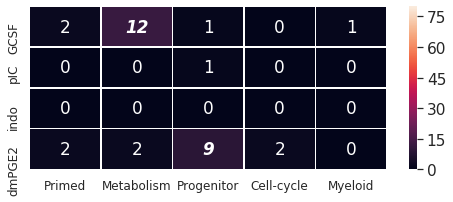

In [21]:
sns.set(font_scale=1.4)

plt.figure(figsize=(8,3))
#sns.heatmap(results_df, annot=True, annot_kws={"size": 16}, mask = p_value_mask)
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)


sns.heatmap(results_df,
            mask = p_value_mask_sig,
            linewidth=0.5,
            annot_kws={"style": "italic", "weight": "bold"},
            annot=True,
            vmin=0, vmax=80)


sns.heatmap(results_df,
            mask = p_value_mask_nonsig,
            linewidth=0.5,
            cbar=False,
            annot=True,
            vmin=0, vmax=80)

plt.savefig("/home/jovyan/work/Z_TRASH/figures/overlap_clusters_treatment_diff_genes_LSKs_July21.pdf", dpi=300, bbox_inches='tight')

### pathway enrich tx

In [22]:
df_save = pd.DataFrame(columns =['Treatment', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

cl_list = ['dmPGE2', 'GCSF', 'pIC']

for cl in cl_list:
    
      
    temp_df = pd.DataFrame()
    df_final = pd.DataFrame(columns =['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

    gene_list = df_st[(df_st['stimulant']==cl) & (df_st['max_coef'] > math.log2(1.2))]['primerid'].tolist()
    
    sources = ["GO:BP"]
    temp_df = pathway_enrich_genes_new(gene_list, sources).head(4)
    temp_df = col_select(temp_df)  
    df_final = df_final.append(temp_df, ignore_index=True)

    sources = ["REAC"]
    temp_df = pd.DataFrame()
    temp_df = pathway_enrich_genes_new(gene_list, sources).head(4)
    temp_df = col_select(temp_df)  
    df_final = df_final.append(temp_df, ignore_index=True)
    
    enr_res = gp.enrichr(gene_list=gene_list,
                             organism='Mouse',
                             gene_sets= pw_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.01)

    temp_df = enr_res.results[enr_res.results['Adjusted P-value'] < 0.01]
    temp_df = temp_df.sort_values(by = 'Adjusted P-value', axis=0, ascending=True).head(6)

    temp_df['Gene Overlap'] = temp_df['Overlap']
    temp_df['Gene names'] = temp_df['Genes']
    
    # extract conditions
    pw_list = []
    origin_list = []
    for index, row in temp_df.iterrows():
        pw = 0
        origin = 0
        pw = row['Term'].split("_", 1)[0]
        origin = row['Term'].split("_", 1)[1] 
        pw_list.append(pw)
        origin_list.append(origin)

    temp_df['Origin'] = pw_list
    temp_df['Pathway'] = origin_list

    temp_df = temp_df[['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]

    df_final = df_final.append(temp_df, ignore_index=True)
    df_final['Adjusted P-value'] = df_final['Adjusted P-value'].apply(lambda x: round(x, 1 - int(floor(log10(abs(x))))))
    df_final['Treatment'] = cl
    df_final = df_final[['Treatment', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]
    df_save = df_save.append(df_final, ignore_index=True)
    
df_save.to_csv('/home/jovyan/work/Z_TRASH/write/MPP_treatment_enrichment.csv', index=False, header=True)

2021-09-02 20:33:01,270 Warning: No enrich terms using library CUSTOM139753620597352 when cutoff = 0.01


In [23]:
# check GCSF separately in MPPs

cl = 'GCSF'

gene_list = df_st[(df_st['stimulant']==cl) & (df_st['max_coef'] > math.log2(1.2))]['primerid'].tolist()

enr_res = gp.enrichr(gene_list=gene_list,
                             organism='Mouse',
                             gene_sets= pw_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.01)

enr_res.results

2021-09-02 20:33:04,749 Warning: No enrich terms using library CUSTOM139753620597352 when cutoff = 0.01


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Genes
0,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_8H_BMDC_DN,4/199,0.528254,0.999939,Lap3;Eif2s2;G3bp2;Ranbp1
1,CUSTOM139753620597352,GSE21033_CTRL_VS_POLYIC_STIM_DC_12H_DN,8/200,0.038117,0.242086,Gmps;G3bp1;Psmb5;Mrps10;Usp10;Ldha;Wdr43;Strap
2,CUSTOM139753620597352,GSE21033_CTRL_VS_POLYIC_STIM_DC_1H_DN,7/198,0.085235,0.298556,Bzw1;Usp7;Baz1a;Aen;Ybx3;Cdv3;Eif4a1
3,CUSTOM139753620597352,CHEMNITZ_RESPONSE_TO_PROSTAGLANDIN_E2_UP,7/147,0.022642,0.242086,Gmps;Larp1;Nop16;Hspa9;Slc7a1;Eif4ebp1;Mthfd2
4,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_0.5H_BMDC_UP,7/200,0.088760,0.298556,Grwd1;Ifitm2;Nsun2;Lrrc59;Lap3;Mogs;Eif2s2
5,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_12H_BMDC_DN,7/200,0.088760,0.298556,Cacybp;Gspt1;Srsf7;Pfdn2;Eif2s1;Dnajb11;Eif2s2
6,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_1H_BMDC_DN,4/199,0.528254,0.999939,Eif2s1;Cebpz;C1qbp;Hspa5
7,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_1H_BMDC_UP,3/200,0.738285,0.999939,Slc7a1;Eif3b;Aprt
8,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_24H_BMDC_DN,6/200,0.183556,0.565966,Hnrnpd;Tgm2;G3bp2;Basp1;Lap3;Ranbp1
9,CUSTOM139753620597352,GSE17721_CTRL_VS_POLYIC_24H_BMDC_UP,3/199,0.735194,0.999939,Tomm20;Xbp1;Pno1


In [24]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.10.25-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.3
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pandas_datareader: None
bs4              : 4.8.1
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.6.3
matplotlib      

In [25]:
! pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
appdirs                1.4.4              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bioservices            1.7.11             
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
colorama               0.4.4              
colorlog               5.0.1              
conda                  4.7.12             
conda-packa